In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [6]:
MODEL_PATH = '/home/makim/personally-attractive-images-generation'

with open(os.path.join(MODEL_PATH, 'stylegan3-r-ffhqu-256x256.pkl'), 'rb') as file:
    loaded_model = pickle.load(file)['G_ema'].cuda()

SEED_SIZE = loaded_model.z_dim
CLASS_LABEL = None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


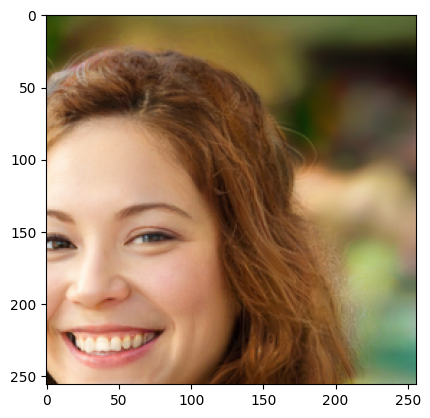

In [7]:
image_seed = torch.randn([1, loaded_model.z_dim]).cuda()

# NCHW, float32, dynamic range [-1, +1], no truncation
generated_image = loaded_model(image_seed, CLASS_LABEL)
generated_image_processed = np.moveaxis(generated_image.cpu().numpy(), 1, -1)
generated_image_processed = 0.5 * generated_image_processed + 0.5
plt.imshow(generated_image_processed[0])

In [8]:
import tkinter as tk
from PIL import Image, ImageTk


STAGES_NUMBER = 5
IMAGE_RESIZE_PIXELS = 256
STAGE_IMAGES_NUMBER_ROW = 2
STAGE_IMAGES_NUMBER_COL = 5
PERSONAL_IMAGES_NUMBER_ROW = 1
PERSONAL_IMAGES_NUMBER_COL = 3


class PersonallyAttractiveImagesApp:
    def __init__(self, root: tk.Tk):
        """Create windows with frame of labels, containing images.

        :param root: root for tkinter application
        """
        # Create root
        self.root = root
        self.root.title("Генерация субъективно привлекательных лиц людей")

        # Set up current choice stage
        self.current_stage = 0

        # List of meta information of selected by user images
        self.selected_images: list[dict[str, object]] = []

        # Set up title lable
        self.title_label = tk.Label(self.root, text=f"Выберите самое привлекательное изображение (этап {self.current_stage + 1}/{STAGES_NUMBER})")
        self.title_label.pack()

        # Create frame for image labels
        self.image_container = tk.Frame(self.root)
        self.image_container.pack()

        # 2D list of labels in frame
        self.frame_labels: list[list[tk.Label]] =\
            [[tk.Label(self.image_container) for _ in range(STAGE_IMAGES_NUMBER_COL)] for _ in range(STAGE_IMAGES_NUMBER_ROW)]
        
        # 2D list of meta information for each label in frame
        self.frame_labels_meta: list[list[dict[str, object]]] =\
            [[{} for _ in range(STAGE_IMAGES_NUMBER_COL)] for _ in range(STAGE_IMAGES_NUMBER_ROW)]
        
        # Add labels with generated images to frame
        for idx_row in range(STAGE_IMAGES_NUMBER_ROW):
            for idx_col in range(STAGE_IMAGES_NUMBER_COL):
                frame_label = tk.Label(self.image_container)
                frame_label.grid(row=idx_row, column=idx_col, padx=10, pady=10)
                frame_label.bind("<Button-1>", lambda _, idx_row=idx_row, idx_col=idx_col, frame_label=frame_label: self.select_image(frame_label, idx_row, idx_col))
                self.update_label(frame_label, idx_row, idx_col)


    def select_image(self, label: tk.Label, idx_row: int, idx_col: int):
        """Pick image selected by user, append it to selected images and start next stage.

        :param label: selected by user label
        :param idx_row: row index of label in grid
        :param idx_col: column index of label in grid
        """
        label.config(bg='green')
        root.update()
        self.selected_images.append(self.frame_labels_meta[idx_row][idx_col])
        self.next_stage()


    def next_stage(self):
        """Start next stage and update labels with new generated images."""        
        self.current_stage += 1

        # If stages are over
        if self.current_stage > STAGES_NUMBER - 1:
            self.root.destroy()
            self.show_personal_images()
            self.show_selected_images()
            

        # If next stage is allowed
        else:

            # Update title label
            self.title_label.config(text=f"Выберите самое привлекательное изображение (этап {self.current_stage + 1}/{STAGES_NUMBER})")

            # Update labels of frame with new generated images
            for idx_row, frame_labels_row in enumerate(self.frame_labels):
                for idx_col, frame_label in enumerate(frame_labels_row):
                    self.update_label(frame_label, idx_row, idx_col)


    def update_label(self, label: tk.Label, idx_row: int, idx_col: int):
        """Update label with new generated image.

        :param label: label in grid
        :param idx_row: row index of label in grid
        :param idx_col: column index of label in grid
        """
        # Generate random or related image depends on label position
        is_random: bool = idx_row >= STAGE_IMAGES_NUMBER_ROW // 2 or len(self.selected_images) == 0
        image, seed = self.generate_image(is_random)

        # Update label
        image_resized = ImageTk.PhotoImage(image.resize((IMAGE_RESIZE_PIXELS, IMAGE_RESIZE_PIXELS)))
        label.config(relief='flat', bg='#D9D9D9', bd=3, image=image_resized)
        label.image = image_resized
        self.frame_labels[idx_row][idx_col] = label

        # Update label meta information
        self.frame_labels_meta[idx_row][idx_col] = {'image': image, 'seed': seed}
        

    def show_selected_images(self):
        """Show selected images."""
        # Create windows based on root
        selected_window = tk.Toplevel(self.root)
        selected_window.title("Выбранные изображения")

        # Create frame for image labels
        selected_frame = tk.Frame(selected_window)
        selected_frame.pack()

        # Add labels with selected images to frame
        for idx, elem in enumerate(self.selected_images):
            frame_label = tk.Label(selected_frame)
            frame_label.grid(row=idx // (STAGES_NUMBER // 2), column=idx % (STAGES_NUMBER // 2), padx=10, pady=10)

            # Update label
            image: Image.Image = elem['image']
            image_resized = ImageTk.PhotoImage(image.resize((IMAGE_RESIZE_PIXELS, IMAGE_RESIZE_PIXELS)))
            frame_label.config(image=image_resized)
            frame_label.image = image_resized


    def show_personal_images(self):
        """Show personal attractive images."""
        # Create root
        self.root = tk.Tk()
        self.root.title("Субъективно привлекательные изображения")

        # Create frame for image labels
        personal_frame = tk.Frame(self.root)
        personal_frame.pack()

        # Add labels with generated images to frame
        for idx_row in range(PERSONAL_IMAGES_NUMBER_ROW):
            for idx_col in range(PERSONAL_IMAGES_NUMBER_COL):
                frame_label = tk.Label(personal_frame)
                frame_label.grid(row=idx_row, column=idx_col, padx=10, pady=10)

                if idx_row == 0 and idx_col == 0:
                    image, _ = self.generate_image(random=False, stddev=.0)

                else:
                    image, _ = self.generate_image(random=False, stddev=.1)

                # Update label
                image_resized = ImageTk.PhotoImage(image.resize((IMAGE_RESIZE_PIXELS, IMAGE_RESIZE_PIXELS)))
                frame_label.config(image=image_resized)
                frame_label.image = image_resized

    def generate_image(self, random: bool, stddev: float = .5):
        """Generate images using GAN model.

        :return: image and noise used to create image
        :rtype: tuple[Image.Image, np.array]
        """        
        if random:

            # Generate random seed and image
            image_seed = torch.randn((1, SEED_SIZE)).cuda()

        else:

            # Calculate average seed of all selected images' seeds
            average_seed = torch.zeros((1, SEED_SIZE)).cuda()
            counter = 0.
            for elem in self.selected_images:
                average_seed += elem['seed']
                counter += 1
            image_seed = average_seed / counter

            # Add some noise to image seed
            image_seed += torch.normal(1, stddev, size=(1, SEED_SIZE)).cuda()

        # NCHW, float32, dynamic range [-1, +1], no truncation
        generated_image = loaded_model(image_seed, CLASS_LABEL)
        generated_image_processed = np.moveaxis(generated_image.cpu().numpy(), 1, -1)
        generated_image_processed = 0.5 * generated_image_processed + 0.5
        
        return Image.fromarray((generated_image_processed[0] * 255).astype(np.uint8)), image_seed



if __name__ == "__main__":
    root = tk.Tk()
    app = PersonallyAttractiveImagesApp(root)
    root.mainloop()